In [6]:
import os
import pathlib 
import pickle

import numpy as np
import cv2
import matplotlib.pyplot as plt
import imageio
from PIL import Image

import importlib
from courtvisionlib.functions import *
import project_config as config
importlib.reload(config)
%matplotlib inline

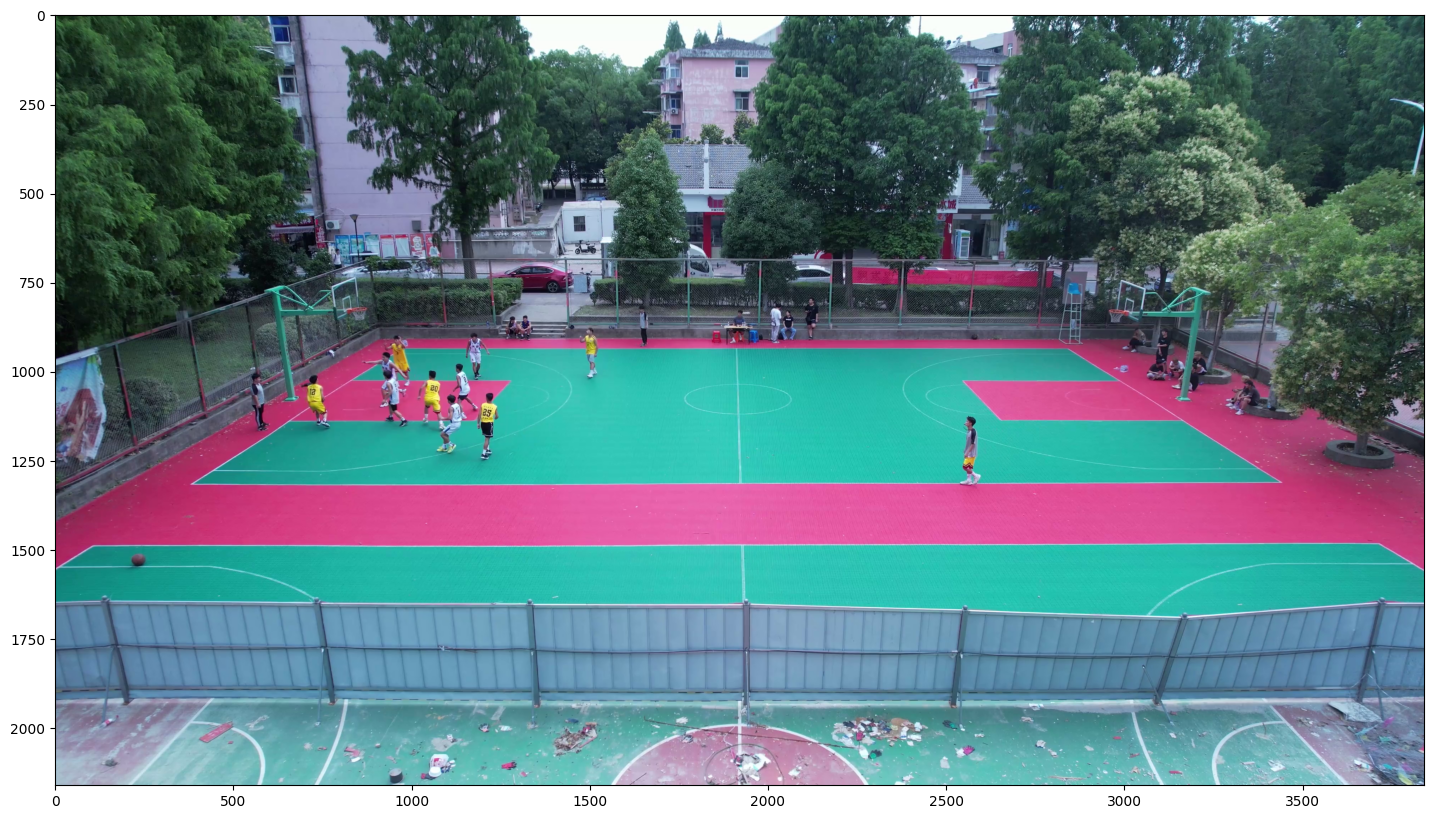

In [7]:
pathlib.Path(config.DATA_PATH).mkdir(parents=True, exist_ok=True)

VIDEO_FILE = 'Q1_side_30-60.mp4'

pickle.dump(VIDEO_FILE, open(f'{config.DATA_PATH}/videopath.p', 'wb'))

# Create folder for images
pathlib.Path('./images/').mkdir(parents=True, exist_ok=True)

# Extract frames
extractFrame(VIDEO_FILE, frameno = (0*60)*15, dest_file = './images/frame_view1.jpg');

In [8]:
SRC = np.float32([
    [973, 932], # Upper left
    [2841, 936], # Upper right
    [383, 1316], # Lower left
    [3440, 1311], # Lower right
    [1915, 1036], # Sign
])

DST = np.float32([
    [88, 91], # Upper left
    [523, 91], # Upper right
    [87, 333], # Lower left
    [523, 334], # Lower right
    [304, 184], # Sign
])

print ('  "cameraPoints" : [[{}, {}], [{}, {}], [{}, {}], [{}, {}]],'.format(
    int(SRC[0][0]), int(SRC[0][1]),
    int(SRC[1][0]), int(SRC[1][1]),
    int(SRC[2][0]), int(SRC[2][1]),
    int(SRC[3][0]), int(SRC[3][1])
))

print ('  "birdEyePoints" : [[{}, {}], [{}, {}], [{}, {}], [{}, {}]],'.format(
    int(DST[0][0]), int(DST[0][1]),
    int(DST[1][0]), int(DST[1][1]),
    int(DST[2][0]), int(DST[2][1]),
    int(DST[3][0]), int(DST[3][1]),
))




  "cameraPoints" : [[973, 932], [2841, 936], [383, 1316], [3440, 1311]],
  "birdEyePoints" : [[88, 91], [523, 91], [87, 333], [523, 334]],


In [9]:
M = cv2.getPerspectiveTransform(SRC[:4], DST[:4])
Minv = cv2.getPerspectiveTransform(DST[:4], SRC[:4])

[973. 932.] -> [88. 91.]
[2841.  936.] -> [523.  91.]
[ 383. 1316.] -> [ 87. 333.]
[3440. 1311.] -> [523. 334.]
[1915. 1036.] -> [303.70837 181.95485]


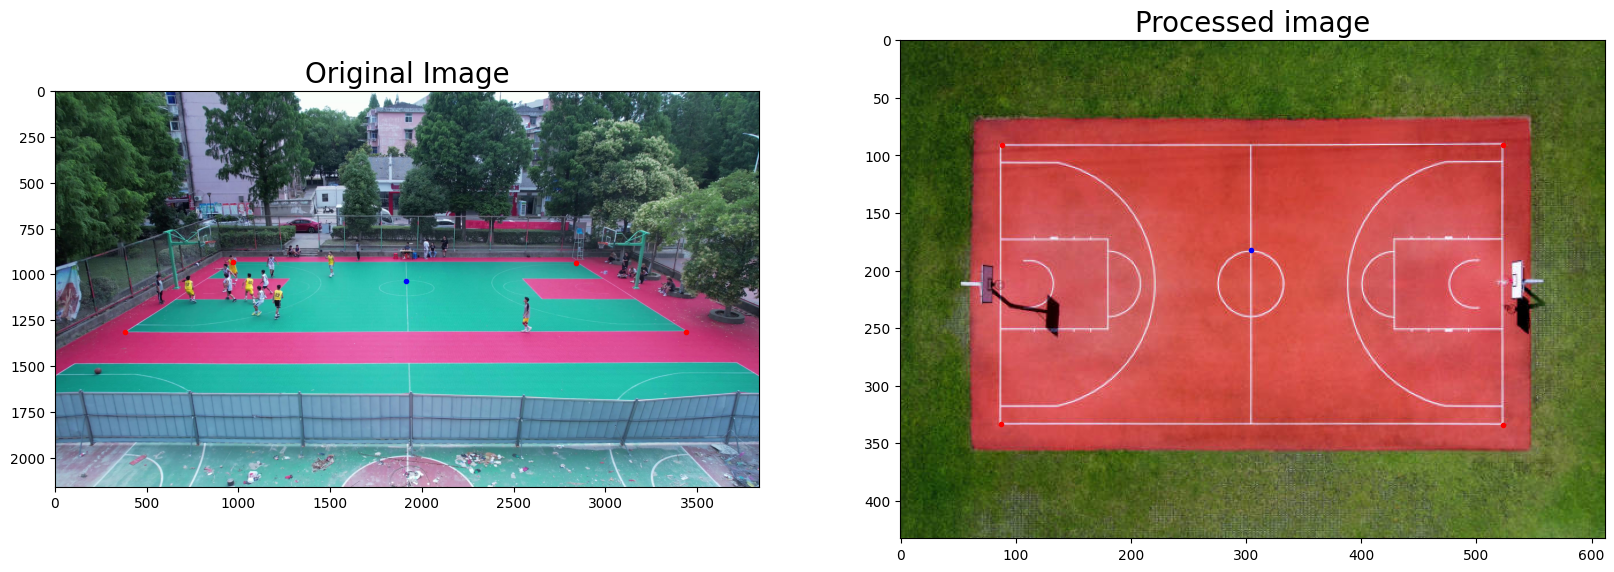

In [10]:
map_file = 'images/Sky View.jpg'
ret = displayPoints(SRC, M, 'images/frame_view1.jpg', map_file)

[88. 91.] -> [973. 932.]
[523.  91.] -> [2841.  936.]
[ 87. 333.] -> [ 383. 1316.]
[523. 334.] -> [3440. 1311.]
[304. 184.] -> [1916.6055 1038.6951]


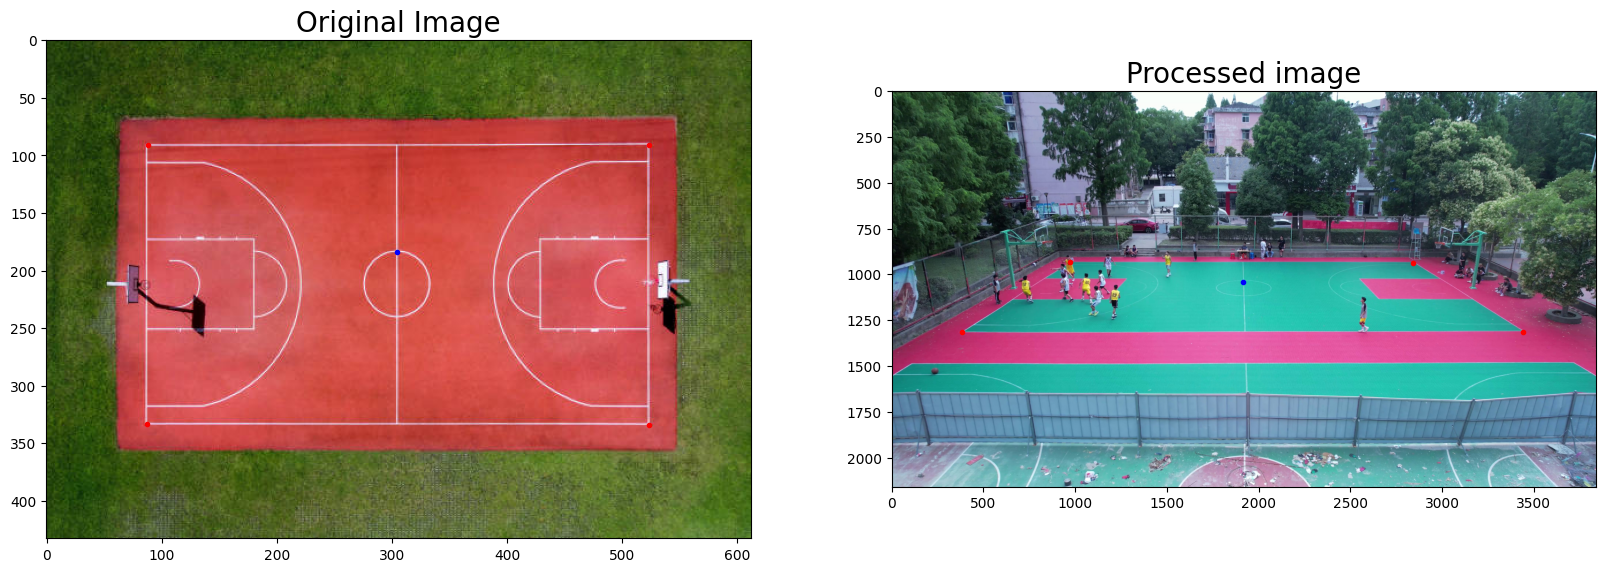

In [11]:
ret = displayPoints(DST, Minv, map_file,  'images/frame_view1.jpg')

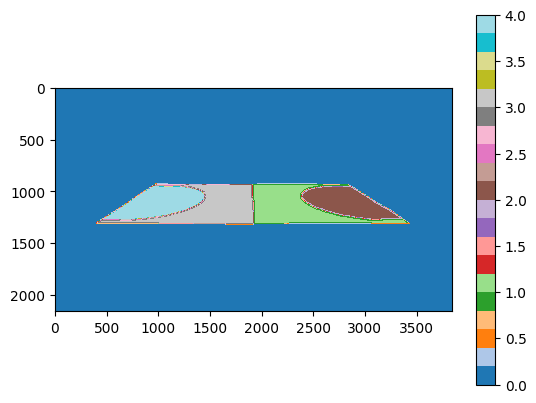

Unique mask values: (array([0, 1, 2, 3, 4]), array([7371773,  271805,  187590,  271359,  191873]))
OK! Mask parameters defined correctly.


In [12]:
MASK_ORG_PATH = 'images/mask_org.png'

# Load the mask image
mask_img = np.array(Image.open(MASK_ORG_PATH).convert('RGB'))

# Define RGB values for each zone
color_to_id = {
    (0, 0, 0): 0,       # Black → Outside
    (0, 255, 2): 1,     # Green → Right 3pt
    (255, 236, 0): 2,   # Yellow → Right 2pt
    (255, 0, 40): 3,    # Red → Left 3pt
    (240, 0, 255): 4    # Pink → Left 2pt
}

# Initialize zone mask
zone_mask = np.zeros(mask_img.shape[:2], dtype=int)

# Tolerance for color matching
tol = 10

# Assign zone IDs
for color, idx in color_to_id.items():
    matches = np.all(np.abs(mask_img - np.array(color)) <= tol, axis=2)
    zone_mask[matches] = idx

# Visualize the zones
plt.imshow(zone_mask, cmap='tab20')
plt.colorbar()
plt.show()

# Check unique IDs and counts
unique = np.unique(zone_mask, return_counts=True)
print("Unique mask values:", unique)

# Optional: validate against expected IDs
expected_ids = [0, 1, 2, 3, 4]
if sorted(unique[0]) == expected_ids:
    print("OK! Mask parameters defined correctly.")
else:
    print(f"Expected IDs: {expected_ids}, Found in image: {sorted(unique[0])}")


In [13]:
import numpy as np

def find_zone_frame_range(player_zones, target_zones):
    """
    Find the first and last frame where a player is in any of the target zones.

    Parameters:
    player_zones (np.ndarray): Array of zone IDs for a player across frames.
    target_zones (list of int): List of zone IDs to search for.

    Returns:
    tuple: (first_frame_index, last_frame_index) or (None, None) if not found.
    """
    matches = np.isin(player_zones, target_zones)
    if np.any(matches):
        first_frame = np.argmax(matches)
        last_frame = len(matches) - 1 - np.argmax(matches[::-1])
        return first_frame, last_frame
    else:
        return None, None


def fix_player_zones(player_zones, start_frame, end_frame, current_zone, new_zone):
    """
    Correct the zone IDs of a player between start_frame and end_frame.

    Parameters:
    player_zones (np.ndarray): Array of zone IDs for a player across frames.
    start_frame (int): Start frame index.
    end_frame (int): End frame index.
    current_zone (int): Zone ID to replace.
    new_zone (int): Zone ID to set.
    """
    if start_frame < 0 or end_frame >= len(player_zones) or start_frame > end_frame:
        raise ValueError("Invalid start_frame or end_frame")

    slice_view = player_zones[start_frame:end_frame+1]
    slice_view[slice_view == current_zone] = new_zone
    player_zones[start_frame:end_frame+1] = slice_view


In [14]:
unique[0][1:]

array([1, 2, 3, 4])

In [15]:
img = cv2.imread('images/frame_view1.jpg')
skyview = cv2.imread('images/Sky View.jpg')

lane_colors = [0, 1, 2, 3, 4]  # From mask: outside, right 3pt, right 2pt, left 3pt, left 2pt

jsonfile = '''{{
  "videoShape" : [{}, {}],
  "birdEyeViewShape" : [{}, {}],

  "cameraPoints" : [[{}, {}], [{}, {}], [{}, {}], [{}, {}]],
  "birdEyePoints" : [[{}, {}], [{}, {}], [{}, {}], [{}, {}]],

  "birdEyeCoordinates" : [[{}, {}], [{}, {}]],
  "lanes_mask" : {}
}}'''.format(
    img.shape[1], img.shape[0],  # videoShape
    skyview.shape[1], skyview.shape[0],  # birdEyeViewShape

    int(SRC[0][0]), int(SRC[0][1]),
    int(SRC[1][0]), int(SRC[1][1]),
    int(SRC[2][0]), int(SRC[2][1]),
    int(SRC[3][0]), int(SRC[3][1]),

    int(DST[0][0]), int(DST[0][1]),
    int(DST[1][0]), int(DST[1][1]),
    int(DST[2][0]), int(DST[2][1]),
    int(DST[3][0]), int(DST[3][1]),

    int(DST[0][0]), int(DST[0][1]),  # birdEyeCoordinates: top-left
    int(DST[1][0]), int(DST[1][1]),  # top-right
    int(DST[2][0]), int(DST[2][1]),  # bottom-left
    int(DST[3][0]), int(DST[3][1]),  # bottom-right
    str(lane_colors)
)

with open('params.json', 'w') as f:
    for line in jsonfile.split('\n'):
        print(line)
        f.write(line + '\n')


{
  "videoShape" : [3840, 2160],
  "birdEyeViewShape" : [612, 433],

  "cameraPoints" : [[973, 932], [2841, 936], [383, 1316], [3440, 1311]],
  "birdEyePoints" : [[88, 91], [523, 91], [87, 333], [523, 334]],

  "birdEyeCoordinates" : [[88, 91], [523, 91]],
  "lanes_mask" : 87
}
